In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the images
img1 = cv2.imread("left1.jpg")
img2 = cv2.imread("right1.jpg")

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# # Show images
# cv2.imshow("Image 1", gray1)
# cv2.imshow("Image 2", gray2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


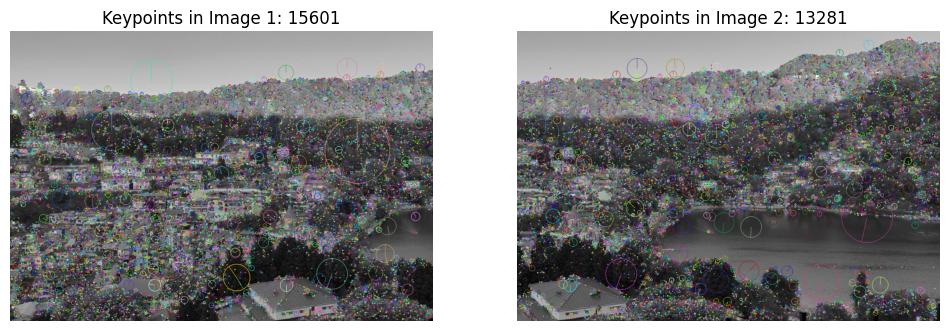

In [6]:
# Create SIFT detector with higher contrast threshold to remove weak keypoints
sift = cv2.SIFT_create(contrastThreshold=0.03)  # Higher value removes low-contrast keypoints

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Draw keypoints on images
img1_kp = cv2.drawKeypoints(gray1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(gray2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display keypoints using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1_kp, cmap='gray')
axes[0].set_title(f"Keypoints in Image 1: {len(kp1)}")
axes[0].axis("off")

axes[1].imshow(img2_kp, cmap='gray')
axes[1].set_title(f"Keypoints in Image 2: {len(kp2)}")
axes[1].axis("off")

# Save the image

# Save the images
plt.imsave("keypoints_image1.png", img1_kp, cmap='gray')
plt.imsave("keypoints_image2.png", img2_kp, cmap='gray')

plt.show()

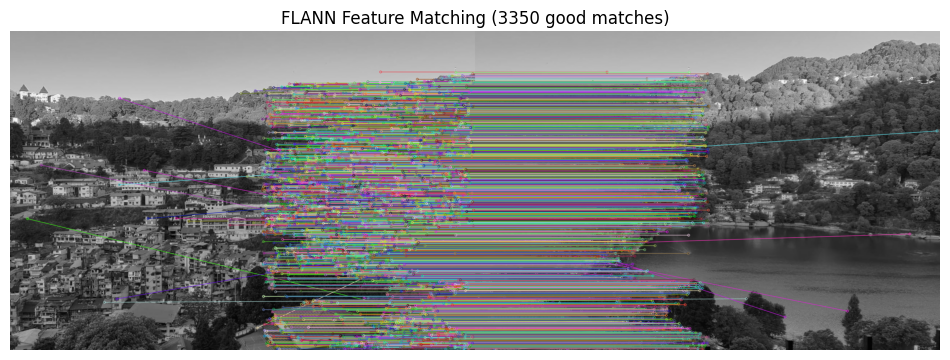

In [7]:
# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# FLANN parameters
index_params = dict(algorithm=1, trees=5)  # KD-Tree for SIFT
search_params = dict(checks=50)  # Number of times the tree is recursively traversed

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)  # KNN with k=2

# Apply Lowe’s ratio test to filter good matches
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# Draw good matches
img_matches = cv2.drawMatches(gray1, kp1, gray2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert BGR to RGB for Matplotlib
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

# Save the image
plt.imsave("feature_matches.png", img_matches_rgb)


# Display using Matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(img_matches_rgb)
plt.title(f"FLANN Feature Matching ({len(good_matches)} good matches)")
plt.axis("off")
plt.show()

Homography Matrix:
 [[ 1.09459011e+00  1.24498893e-05 -7.53954981e+02]
 [ 5.99731744e-05  1.00002939e+00 -5.23313113e-02]
 [ 2.53930453e-08  2.82413044e-08  1.00000000e+00]]


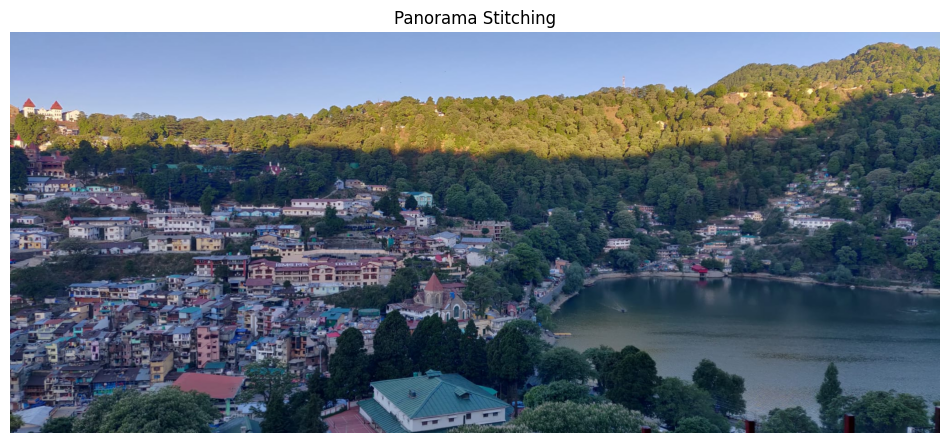

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

if len(good_matches) > 4:
    # Extract matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute homography
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    print("Homography Matrix:\n", H)

    # Get dimensions of img1 and img2
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Warp img1 using homography
    corners_img1 = np.array([
        [0, 0], [width1, 0], [width1, height1], [0, height1]
    ], dtype=np.float32).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Compute final bounding box
    min_x = min(warped_corners[:, 0, 0].min(), 0)
    min_y = min(warped_corners[:, 0, 1].min(), 0)
    max_x = max(warped_corners[:, 0, 0].max(), width2)
    max_y = max(warped_corners[:, 0, 1].max(), height2)

    # Compute final panorama size
    pano_width = int(max_x - min_x)
    pano_height = int(max_y - min_y)

    # Adjust translation matrix
    translation_matrix = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ], dtype=np.float32)

    # Warp img1 into panorama space
    H_adjusted = translation_matrix @ H
    img1_warped = cv2.warpPerspective(img1, H_adjusted, (pano_width, pano_height))

    # Create the final panorama
    panorama = img1_warped.copy()

    # Overlay img2 at the correct position
    x_offset = int(-min_x)
    y_offset = int(-min_y)
    panorama[y_offset:y_offset+height2, x_offset:x_offset+width2] = img2

    # Convert BGR to RGB for display
    panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
    # Save the stitched panorama image
    plt.imsave("panorama_result.png", panorama_rgb)

    # Display the result
    plt.figure(figsize=(12, 6))
    plt.imshow(panorama_rgb)
    plt.title("Panorama Stitching")
    plt.axis("off")
    plt.show()

else:
    print("Not enough matches to compute homography!")
